In [22]:
!pip install -U spacy[cuda111]

In [ ]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4 MB 512 kB/s 


In [1]:
import spacy
import pandas as pd
import os
import pickle
gpu = spacy.prefer_gpu()
print('GPU', gpu)

GPU True


In [2]:
charmeta = pd.read_csv('https://raw.githubusercontent.com/rmb176/MovieGenderBias/main/character.metadata.tsv', sep='\t')
charmeta.head(20)

,Wiki ID,Freebase ID,Release Date,Character Name,Actor DOB,Gender,Height (M),Ethnicity,Actor Name,Actor Age,FB Char/Act ID,FB Char ID,FB Act ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
5,975900,/m/03vyhn,2001-08-24,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
6,975900,/m/03vyhn,2001-08-24,Whitlock,1945-08-02,F,1.753,NaN,Joanna Cassidy,56.0,/m/02vd6kw,/m/0bgchmx,/m/06lj1m
7,975900,/m/03vyhn,2001-08-24,Big Daddy Mars,NaN,M,NaN,NaN,Richard Cetrone,NaN,/m/0bgchsy,/m/0bgcht0,/m/0bgcht7
8,975900,/m/03vyhn,2001-08-24,Michael Descanso,1971-03-20,M,1.892,NaN,Liam Waite,30.0,/m/03jqhb0,/m/0bgchs4,/m/0ks8b0
9,975900,/m/03vyhn,2001-08-24,Uno,NaN,M,NaN,NaN,Duane Davis,NaN,/m/0bgchtj,/m/0bgchtm,/m/03nrwdy


In [3]:
#Total number of character entries in the dataset
len(charmeta)

450669

In [4]:
#Drop all entries with null character name
charmeta = charmeta.dropna(axis=0, subset=['Character Name'])
len(charmeta)

192794

In [5]:
mvmeta = pd.read_csv("https://raw.githubusercontent.com/rmb176/MovieGenderBias/main/movie.metadata.tsv", sep='\t')
mvmeta.head(10)

,Wiki ID,Freebase ID,Movie Name,Release Date,Box Office,Runtime,Language,Country Origin,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant..."
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ..."
8,9997961,/m/06_y2j7,Contigo y aquí,1974,NaN,NaN,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0jgd"": ""Argentina""}","{""/m/04t36"": ""Musical"", ""/m/07s9rl0"": ""Drama"",..."
9,2345652,/m/075f66,City of the Dead,1960,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur..."


In [6]:
#Total number of movies in the dataset
len(mvmeta)

81741

In [7]:
summs = pd.read_csv('https://raw.githubusercontent.com/rmb176/MovieGenderBias/main/plot_summaries.txt', sep='\t')
summs.head(10)

,Wiki ID,Summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...
5,5272176,The president is on his way to give a speech. ...
6,1952976,"{{plot}} The film opens in 1974, as a young gi..."
7,24225279,"The story begins with Hannah, a young Jewish t..."
8,2462689,Infuriated at being told to write one final co...
9,20532852,A line of people drool at the window of the s...


In [8]:
#Collect all of the character metadata into lists associated with a movie ID
charsets = {}
for ind in charmeta.index:
  id = charmeta['Wiki ID'][ind]
  if id in charsets:
    charsets[id].append([charmeta['Character Name'][ind], charmeta['Gender'][ind]])
  else:
    charsets[id] = [[charmeta['Character Name'][ind], charmeta['Gender'][ind]]]




#Put the character data into a two column DataFrame to merge with the appropriate movies
df = pd.DataFrame.from_dict(charsets, orient="index")
columns = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,114]
df['Characters'] = df[columns].to_dict(orient='records')
df = df.drop(columns=columns)
df.index.name = 'Wiki ID'
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  app.launch_new_instance()


,Characters
Wiki ID,
975900,"{0: ['Akooshay', 'F'], 1: ['Lieutenant Melanie..."
3196793,"{0: ['Police Officer', 'M'], 1: ['Reporter', '..."
2238856,"{0: ['Michael', 'M'], 1: ['Richard Swersey', '..."
2314463,"{0: ['Taper Guy', 'M'], 1: None, 2: None, 3: N..."
612710,"{0: ['Sandii', 'F'], 1: ['Fox', 'M'], 2: ['Mad..."


In [9]:
#Merge the movie metadata with the respective summaries
movies = pd.merge(left=mvmeta, right=summs, left_on='Wiki ID', right_on='Wiki ID')
movies.head(10)

,Wiki ID,Freebase ID,Movie Name,Release Date,Box Office,Runtime,Language,Country Origin,Genres,Summary
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra..."
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","Every hundred years, the evil Morgana returns..."
4,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...","Adam, a San Francisco-based artist who works a..."
5,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...
6,18296435,/m/04cqrs4,Aaah Belinda,1986,NaN,NaN,"{""/m/02hwyss"": ""Turkish Language""}","{""/m/01znc_"": ""Turkey""}","{""/m/01z4y"": ""Comedy""}","Serap, a young actress with a strong, lively p..."
7,11250635,/m/02r52hc,The Mechanical Monsters,NaN,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...",The story starts as one of the robots flies i...
8,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",The film opens with Mary Poppins perched in a...
9,32456683,/m/0gyryjt,Die Fahne von Kriwoj Rog,1967,NaN,108.0,"{""/m/04306rv"": ""German Language""}","{""/m/03f2w"": ""German Democratic Republic""}",{},"Otto Brosowski, a communist miner, writes to t..."


In [10]:
#Not every movie has a summary, dataset is cut roughly in half
len(movies)

42204

In [11]:
movies = pd.merge(left=movies, right=df, left_on='Wiki ID', right_on='Wiki ID')
movies.head(10)

,Wiki ID,Freebase ID,Movie Name,Release Date,Box Office,Runtime,Language,Country Origin,Genres,Summary,Characters
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th...","{0: ['Akooshay', 'F'], 1: ['Lieutenant Melanie..."
1,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","Every hundred years, the evil Morgana returns...","{0: ['Morgana', 'F'], 1: None, 2: None, 3: Non..."
2,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...","Adam, a San Francisco-based artist who works a...","{0: ['Rebecca', 'F'], 1: ['Nina', 'F'], 2: Non..."
3,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,"{0: ['Henry V', 'M'], 1: ['Catherine of Valois..."
4,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",The film opens with Mary Poppins perched in a...,"{0: ['Jane Banks', 'F'], 1: ['George Banks', '..."
5,156558,/m/014k4y,Baby Boy,2001-06-27,29381649.0,123.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",A young 20-year-old named Jody lives with his...,"{0: ['Yvette', 'F'], 1: ['Jody', 'M'], 2: ['Já..."
6,11448183,/m/02rc_h4,Bindiya Chamkegi,1984-01-20,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}","{""/m/0hqxf"": ""Family Film"", ""/m/01z4y"": ""Comedy""}",Shalini 'Shalu' lives a wealthy lifestyle with...,"{0: ['Havaldar', 'M'], 1: ['Bindiya', 'F'], 2:..."
7,9633533,/m/02pml15,Vandanam,1989,NaN,168.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/02kdv5l"": ""Action""}","Professor Kurian Fernandez , a convict escapes...","{0: ['Unnikrishnan', 'M'], 1: ['Advertising Bo..."
8,29528534,/m/04j0lfk,Anokha Rishta,1986,NaN,180.0,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}","{""/m/03q4nz"": ""World cinema"", ""/m/04t36"": ""Mus...","Mary, an orphan lives in an orphanage run by n...","{0: ['Dr. Pramila', 'F'], 1: ['Robert Bob', 'M..."
9,29772142,/m/0fq260_,Karayilekku Oru Kadal Dooram,2010-12-31,NaN,110.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/07s9rl0"": ""Drama""}","Anoop Chandran , is a famous writer and award ...","{0: ['Gatha', 'F'], 1: ['Sathyabhama', 'F'], 2..."


In [12]:
#Not every movie has character metadata, dataset is cut roughly in half again
len(movies)

23068

In [ ]:
from contextlib import nullcontext
from spacy.lemmatizer import Lemmatizer
import en_core_web_md
movies['Bias'] = 0

nlp = spacy.load("en_core_web_sm")
wordvec = en_core_web_md.load()
lemmatizer = nlp.vocab.morphology.lemmatizer

In [ ]:
mwords = "attack anger swear sexual independent achieve"
fwords = "submissive home money family social friends"
mdoc = wordvec(mwords)
fdoc = wordvec(fwords)

## Taken from https://stackoverflow.com/questions/64422129/how-to-extract-noun-and-adjective-pairs-including-conjunctions

def subjgend(subj, charlist):
  pronoun = lemmatizer(subj, 'PRON')[0]
  if pronoun in {'he', 'him', 'his'}:
    return 'M'
  if pronoun in {'she', 'her', 'hers'}:
    return 'F'
  if pronoun in {'who', 'it', 'whom', 'i', 'me'}:
    return 'N'
  for i in charlist:
    if charlist[i] == None:
      break
    if subj in charlist[i][0]:
      return charlist[i][1]
  return 'N'

def descgend(desc):
  desctok = wordvec(desc)[0]
  for tok in mdoc:
    if tok.similarity(desctok) > 0.4:
      return 'M'
  for tok in fdoc:
    if tok.similarity(desctok) > 0.4:
      return 'F'
  return 'N'


def calcbias(row):
  noun_adj_pairs = {}
  summ = row[9]
  chars = row[10]
  doc = nlp(summ)
  for chunk in doc.noun_chunks:
      adj = []
      noun = ""
      for tok in chunk:
          if tok.pos_ == "PROPN" or tok.pos_ == "PRON":
              noun = tok.text
              if tok.head.pos_ == "VERB":
                adj.append(tok.head.text)
          if tok.pos_ == "ADJ":
              adj.append(tok.text)
      if noun:
          noun_adj_pairs.update({noun:adj})
## End cited code
  stereotype = 0
  total = 0
  for char in noun_adj_pairs:
    subj = subjgend(char, chars)
    for desc in noun_adj_pairs[char]:
      dgen = descgend(desc)
      if dgen == 'N' or subj == 'N':
        total += 1
        continue
      if subj == dgen:
        stereotype += 1
      total += 1
  if total == 0:
    return None
  return stereotype/total

movies['Bias'] = movies.apply(calcbias, axis=1)
movies.head(10)
#for token in doc:
#    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
#            token.shape_, token.is_alpha, token.is_stop)

In [13]:
import random
def ran(row):
  return random.random()

movies['Bias'] = movies.apply(ran, axis=1)
movies.head(10)

,Wiki ID,Freebase ID,Movie Name,Release Date,Box Office,Runtime,Language,Country Origin,Genres,Summary,Characters,Bias
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th...","{0: ['Akooshay', 'F'], 1: ['Lieutenant Melanie...",0.294640
1,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","Every hundred years, the evil Morgana returns...","{0: ['Morgana', 'F'], 1: None, 2: None, 3: Non...",0.512671
2,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...","Adam, a San Francisco-based artist who works a...","{0: ['Rebecca', 'F'], 1: ['Nina', 'F'], 2: Non...",0.731826
3,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,"{0: ['Henry V', 'M'], 1: ['Catherine of Valois...",0.560011
4,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",The film opens with Mary Poppins perched in a...,"{0: ['Jane Banks', 'F'], 1: ['George Banks', '...",0.950788
5,156558,/m/014k4y,Baby Boy,2001-06-27,29381649.0,123.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",A young 20-year-old named Jody lives with his...,"{0: ['Yvette', 'F'], 1: ['Jody', 'M'], 2: ['Já...",0.479913
6,11448183,/m/02rc_h4,Bindiya Chamkegi,1984-01-20,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}","{""/m/0hqxf"": ""Family Film"", ""/m/01z4y"": ""Comedy""}",Shalini 'Shalu' lives a wealthy lifestyle with...,"{0: ['Havaldar', 'M'], 1: ['Bindiya', 'F'], 2:...",0.091881
7,9633533,/m/02pml15,Vandanam,1989,NaN,168.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/02kdv5l"": ""Action""}","Professor Kurian Fernandez , a convict escapes...","{0: ['Unnikrishnan', 'M'], 1: ['Advertising Bo...",0.129465
8,29528534,/m/04j0lfk,Anokha Rishta,1986,NaN,180.0,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}","{""/m/03q4nz"": ""World cinema"", ""/m/04t36"": ""Mus...","Mary, an orphan lives in an orphanage run by n...","{0: ['Dr. Pramila', 'F'], 1: ['Robert Bob', 'M...",0.731573
9,29772142,/m/0fq260_,Karayilekku Oru Kadal Dooram,2010-12-31,NaN,110.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/07s9rl0"": ""Drama""}","Anoop Chandran , is a famous writer and award ...","{0: ['Gatha', 'F'], 1: ['Sathyabhama', 'F'], 2...",0.655332


In [14]:
movies.head()

,Wiki ID,Freebase ID,Movie Name,Release Date,Box Office,Runtime,Language,Country Origin,Genres,Summary,Characters,Bias
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th...","{0: ['Akooshay', 'F'], 1: ['Lieutenant Melanie...",0.294640
1,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","Every hundred years, the evil Morgana returns...","{0: ['Morgana', 'F'], 1: None, 2: None, 3: Non...",0.512671
2,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...","Adam, a San Francisco-based artist who works a...","{0: ['Rebecca', 'F'], 1: ['Nina', 'F'], 2: Non...",0.731826
3,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,"{0: ['Henry V', 'M'], 1: ['Catherine of Valois...",0.560011
4,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",The film opens with Mary Poppins perched in a...,"{0: ['Jane Banks', 'F'], 1: ['George Banks', '...",0.950788


In [23]:
movies[['Release Date']] = movies[['Release Date']].astype(str)

In [44]:
movies2 = movies[movies['Release Date'].map(len) == 4]
movies2[['Release Date']] = movies2[['Release Date']].astype(int)
len(movies2)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


6952

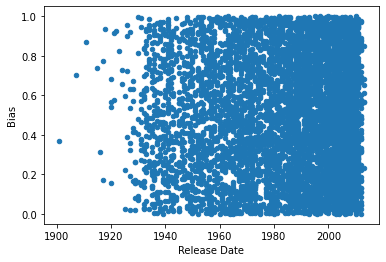

In [43]:
import matplotlib.pyplot as plt
movies2.plot(x = 'Release Date', y = "Bias", kind="scatter")
plt.show()

```
for movie in movies DataFrame:
  charlist = movie['Characters']
	run NLP on the summary to get a doc of tokens
	use the dependency tokens to collect a list of subject verb and subject adjective pairs
	for each pair in the list:
		gendpair = [subjgend(subject lemma, charlist), descgend(adjective/verb lemma)]
		if subjgend == descgend:
			stereotype++
		total++
	movie['Bias'] = stereotype/total

def subjgend(subj, charlist):
	if subj == 'he':
		return 'male'
	if subj == 'she':
		return 'female'
	for char in charlist:
		if char[0] == subj:
			return char[1]

def descgend(desc):
	if(desclist.contains(desc)):
		return desclist[desc]
	return 'neutral'
```





In [ ]:
! nvidia-smi

Sat Apr 16 02:20:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------